In [1]:
import sys
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models')
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models/modules')
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models/data')
from RecurrentNets import *
from decoding import *
from numpy import *
from dynamicstools import *
from plottingtools import *
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import rc_parameters
from numpy.linalg import multi_dot, inv, eigvals
from sklearn.metrics import roc_auc_score, auc
from scipy.stats import norm
from scipy import linalg
rcParams.update({
    "text.usetex": False, "axes.spines.top":False, "axes.spines.right":False})
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/final_fig_panels/ED_Fig5/'

In [2]:
# Set up steady state model
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
D_EI = linspace(-2, 2, n)
D_IE = array([0.4,1,1.6])
D_II = 0.

amplification       = empty((len(D_IE),len(D_EI)))
suppression      = empty((len(D_IE),len(D_EI)))
distance = empty((len(D_IE),len(D_EI)))

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            amplification[i_IE, i_EI] = nan
            suppression[i_IE, i_EI]   = nan
            distance[i_IE, i_EI] = nan
        else:
            alpha = 1 - S_EE + S_EI * S_IE
            delta = 1 - D_EE + D_EI[i_EI] * D_IE[i_IE]

            amplification[i_IE, i_EI] = (1 / alpha + 1 / delta) / 2
            suppression[i_IE, i_EI] = (1 / alpha - 1 / delta) / 2
            distance[i_IE, i_EI] = 1 / delta


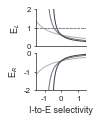

In [3]:
# ED Fig 8b: steady_state_E1_E2
fig = figure(figsize=(1.4,1.8)) #smalle (v4)
# Suppression
ax = fig.add_subplot(2,1,2)
format_axes(ax,'0')
col = ['#b3b3b3', '#6d757d', '#35424f']
labels = [r'$\Delta_{IE} = 0.6$', r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 1.4$']
for i in range(len(D_IE)):
    ax.plot(D_EI, suppression[i,:], lw=1., color=col[i], label=labels[i])
    ax.plot([-1.5,1.5],[1,1],'--', lw=0.7, color='grey')
    ax.set_ylim(-2,0)
    ax.set_yticks([0,-1,-2])
    ax.set_xlim(-1.5,1.5)
    ax.set_ylabel(r'E$_R$')
    ax.set_xlabel('I-to-E selectivity')
tight_layout()

# Amplification
ax = fig.add_subplot(2,1,1)
format_axes(ax,'0')
# col = ['#8aaced', '#4775cc', '#073894']
# labels = [r'$\Delta_{IE} = 0.6$', r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 1.4$']
labels = [r'E-to-I sel. = 0.6', r'E-to-I sel. = 1', r'E-to-I sel. = 1.4']
for i in range(len(D_IE)):
    ax.plot(D_EI, amplification[i,:], lw=1., color=col[i], label=labels[i])
    ax.plot([-1.5,1.5],[1,1],'--', lw=0.7, color='grey')
    ax.set_ylim(0,2)
    ax.set_xlim(-1.5,1.5)
    ax.set_xticks([])
    ax.set_yticks([0,1,2])
    ax.set_ylabel(r'E$_L$')
# legend(frameon=0, fontsize=9)

tight_layout()
plt.subplots_adjust(hspace = 0.2) 
# plt.savefig(figsDir+'ED5b_steady_state_E1_E2.pdf', dpi=300, bbox_inches='tight')

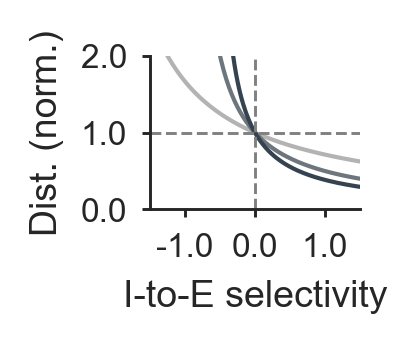

In [4]:
## ED Fig 8c: distance of mean activities
# fig,ax=my_figure(figsize=(1.9,1.6))
fig,ax=my_figure(figsize=(1.4,1.2))

for i in range(len(D_IE)):
    ax.plot(D_EI, distance[i,:], lw=1., color=col[i])
ax.set_ylim(0,2)
ax.set_xlim(-1.5,1.5)

ax.plot([0,0],[0,2],'--', lw=0.7, color='grey')
ax.plot([-1.5,1.5],[1,1],'--', lw=0.7, color='grey')

ax.set_xlabel(r'I-to-E selectivity')
ax.set_ylabel('Dist. (norm.)')
tight_layout()

# plt.savefig(figsDir+'ED5c_distance_mean_activities.pdf',bbox_inches='tight', dpi=300)

In [5]:
# Set up decoding accuracy model
n = 120 # fine grain ness of model (was 120)
S_EE = 0
S_EI = 2
S_IE = 2
S_II = 0.

D_EE = S_EE
D_EI = linspace(-S_EI, S_EI, n)
D_IE = linspace(0, S_IE, n)
D_II = 0.


selectivity_E1    = empty((len(D_IE),len(D_EI)))
selectivity_E2    = empty((len(D_IE),len(D_EI)))
selectivity_I1    = empty((len(D_IE),len(D_EI)))
selectivity_I2    = empty((len(D_IE),len(D_EI)))
decodacc_E     = empty((len(D_IE),len(D_EI)))
decodacc_EI    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh = empty((len(D_IE),len(D_EI)))

selectivity_E1_0    = empty((len(D_IE),len(D_EI)))
selectivity_E2_0    = empty((len(D_IE),len(D_EI)))
selectivity_I1_0    = empty((len(D_IE),len(D_EI)))
selectivity_I2_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh_0  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh_0 = empty((len(D_IE),len(D_EI)))

amplification = empty((len(D_IE),len(D_EI)))
suppression = empty((len(D_IE),len(D_EI)))

N = 4
sigma_input = 0
sigma_obs = 1
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_sh[i_IE, i_EI]  = nan
            decodacc_E_sh[i_IE, i_EI]   = nan

        else:
            # set connectivity matrix
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            alpha = 1-S_EE+S_EI*S_IE
            delta = 1-D_EE+D_EI[i_EI]*D_IE[i_IE]

            amplification[i_IE, i_EI] = (1/alpha+1/delta)/2
            suppression[i_IE, i_EI] = (1/alpha-1/delta)/2

            J    = block([[Win, Wout], [Wout, Win]])
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs * eye(N)
            decodacc_EI[i_IE, i_EI], decodacc_EI_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI], decodacc_E_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0, 2])
            # selectivity_E1[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], decodacc_EI_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI], decodacc_E_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            # selectivity_E1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

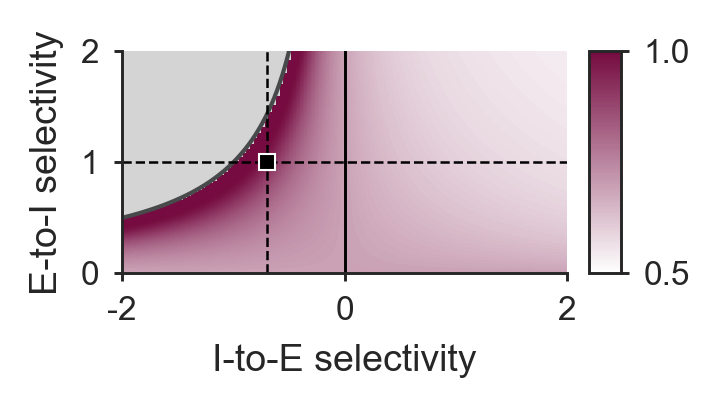

In [6]:
# ED Fig. 8d: decoding accuracy phase plot
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

#fig,ax = my_figure(figsize=(2.4,1.9))
fig,ax = my_figure(figsize=(2.5,1.8))
format_axes(ax, '0','0')
colors = ['w','#750b40']
cm = define_colormap(colors,100)
Z = decodacc_E

Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')
clim = (0.5,1)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')


x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

xlim = (-2,2)
ylim = (0,2)

xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')
plot([-0.7,-0.7],[0,2], lw=0.6, ls='--', color='k')
plot([-0.7],[1],'s', markersize=4, markeredgecolor='w', markeredgewidth=0.5, color='k')

#cbar = fig.colorbar(c, ticks=(0.5,1), fraction=0.025).set_label('Decod. \n accuracy')
# Put colorbar on right
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = fig.colorbar(c, cax=cax, orientation="vertical",ticks=(0.5,1))#.set_label('Decod. \n accuracy')
#cax.xaxis.set_ticks_position("top")
#cax.xaxis.set_label_position("top")

ax.set_xticks([-2,0,+2])

tight_layout()
# plt.savefig(figsDir+'ED5d_decod_acc_obsnoise_phaseplot_half.pdf',bbox_inches='tight')

In [11]:
# setup E-to-I cuts
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
# D_EI = linspace(-S_EI, S_EI, n)
D_EI = array([-0.7])
D_IE = linspace(0, 2, n)
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))
decodacc_E1      = empty((len(D_IE),len(D_EI)))
decodacc_E2      = empty((len(D_IE),len(D_EI)))
decodacc_I1      = empty((len(D_IE),len(D_EI)))
decodacc_I2      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E1_0    = empty((len(D_IE),len(D_EI)))
decodacc_E2_0    = empty((len(D_IE),len(D_EI)))
decodacc_I1_0    = empty((len(D_IE),len(D_EI)))
decodacc_I2_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 0
sigma_obs = 2
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan

            decodacc_E1[i_IE, i_EI]   = nan
            decodacc_E2[i_IE, i_EI]   = nan
            decodacc_E1_0[i_IE, i_EI] = nan
            decodacc_E2_0[i_IE, i_EI] = nan

            decodacc_I1[i_IE, i_EI]   = nan
            decodacc_I2[i_IE, i_EI]   = nan
            decodacc_I1_0[i_IE, i_EI] = nan
            decodacc_I2_0[i_IE, i_EI] = nan

        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs**2 * eye(N)

            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0,2])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])

##
# set parameters
T = 200
nsteps = 2000
t = linspace(0, T, nsteps)
N = 4
ntrials = 5000
R0 = zeros(N)
f = lambda x:x


nsim = 15
D_IE = linspace(D_IE[0], D_IE[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))

h1 = array([1,0,0,0])
h2 = array([0,0,1,0])
h1 = h1 / linalg.norm(h1-h2)
h2 = h2 / linalg.norm(h1-h2)

# compute decoding accuracy WITHOUT recurrent connections using single-trial simulations
input = outer(h1, ones(nsteps))
pars = {'N': N, 't':t, 'R0':zeros(N), 'J':zeros((N,N)), 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_1 = R[:,-1]
R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

# set second input and compute fixed point
input = outer(h2, ones(nsteps))
pars = {'N': N, 't': t, 'R0': zeros(N), 'J': zeros((N,N)), 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_2 = R[:, -1]
R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

S = hstack((ones(ntrials), -ones(ntrials)))
R = hstack((R_singletrials_1, R_singletrials_2))
clf = LinearSVM(R,S)
clf_E = LinearSVM(R[[0,2],:], S)
clf.set_K(5)
clf_E.set_K(5)
decodacc_EI_0_sim  = mean(clf.get_accuracy())
decodacc_E_0_sim   = mean(clf_E.get_accuracy())


# compute decoding accuracy WITH recurrent connections using single-trial simulations
for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(i_EI)

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan

        else:
            print(d)

            # set first input and compute fixed point
            input = outer(h1, ones(nsteps))
            pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_1 = R[:,-1]
            R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

            # set second input and compute fixed point
            input = outer(h2, ones(nsteps))
            pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_2 = R[:, -1]
            R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf_E1 = LinearSVM(R[[0], :], S)
            clf_E2 = LinearSVM(R[[2],:], S)
            clf_I1 = LinearSVM(R[[1], :], S)
            clf_I2 = LinearSVM(R[[3], :], S)
            clf.set_K(10)
            clf_E.set_K(10)
            clf_E1.set_K(10)
            clf_E2.set_K(10)
            clf_I1.set_K(10)
            clf_I2.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())

0
1.1102230246251565e-16
0
0.3162277660168379
0
0.44721359549995787
0
0.5477225575051662
0
0.6324555320336759
0
0.7071067811865474
0
0.7745966692414833
0
0.8366600265340757
0
0.8944271909999159
0
0.9486832980505139
0
0
0
0
0


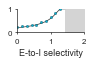

In [12]:
# ED 5d top: E-to-I cut decoding accuracy 
#figsize=(1.6,1)
figsize=(1.4,1.0)
fig = figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
format_axes(ax, '0','0')
black = '#313333'

limx = [0,2]
#limx = [-0.05,1.5]
limy1,limy2 = 0.5,1.

n = 200
D_IE_1 = linspace(D_IE[0], D_IE[-1], n)
Lim = (D_EE-1)/D_EI
D_IE_2 = linspace(D_IE[0], D_IE[-1], nsim)

# colors = ['w','#750b40']
# cm = define_colormap(colors,100)
for i in range(len(D_EI)):
    plot(D_IE_1, decodacc_E[:, i], lw=0.7, color=black)
    plot(D_IE_2, decodacc_E_sim[:, i], '.', \
        markeredgewidth=0.2, markeredgecolor='k', markersize=5, color='#0db0d1')
#     ysim = decodacc_E_sim[:, i]
#     plt.scatter(D_IE_2, ysim, c=ysim, s=10, linewidths = 0.5, edgecolors='k',cmap=cm)

a = abs(D_EI[0])
fill_between([Lim[0], 2], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

xlabel('E-to-I selectivity')
#ylabel('Decod. \n accuracy')
plt.xlim(limx)
yticks([0.5,1])
plt.ylim([limy1,limy2])
plt.xticks([0,1,2 ])
tight_layout()

# plt.savefig(figsDir+'ED5d_top_decoding_accuracy_IE_cut.pdf',bbox_inches='tight')

In [13]:
# Set up I-to-E cuts
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
# D_EI = linspace(-S_EI, S_EI, n)
D_EI = linspace(-2, 2, n)
D_IE = array([1])
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))
decodacc_E1      = empty((len(D_IE),len(D_EI)))
decodacc_E2      = empty((len(D_IE),len(D_EI)))
decodacc_I1      = empty((len(D_IE),len(D_EI)))
decodacc_I2      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E1_0    = empty((len(D_IE),len(D_EI)))
decodacc_E2_0    = empty((len(D_IE),len(D_EI)))
decodacc_I1_0    = empty((len(D_IE),len(D_EI)))
decodacc_I2_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 0
sigma_obs = 2
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan

            decodacc_E1[i_IE, i_EI]   = nan
            decodacc_E2[i_IE, i_EI]   = nan
            decodacc_E1_0[i_IE, i_EI] = nan
            decodacc_E2_0[i_IE, i_EI] = nan

            decodacc_I1[i_IE, i_EI]   = nan
            decodacc_I2[i_IE, i_EI]   = nan
            decodacc_I1_0[i_IE, i_EI] = nan
            decodacc_I2_0[i_IE, i_EI] = nan

        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs**2 * eye(N)

            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0,2])
            # decodacc_E1[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx = [0])
            # decodacc_E2[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[2])
            # decodacc_I1[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[1])
            # decodacc_I2[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[3])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            # decodacc_E1_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[0])
            # decodacc_E2_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[2])
            # decodacc_I1_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[1])
            # decodacc_I2_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[3])

##
# set parameters
T = 200
nsteps = 2000
t = linspace(0, T, nsteps)
N = 4
ntrials = 5000
R0 = zeros(N)
f = lambda x:x


nsim = 15
D_EI = linspace(D_EI[0], D_EI[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E1_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E2_sim      = empty((len(D_IE),len(D_EI)))
decodacc_I1_sim      = empty((len(D_IE),len(D_EI)))
decodacc_I2_sim      = empty((len(D_IE),len(D_EI)))

h1 = array([1,0,0,0])
h2 = array([0,0,1,0])
h1 = h1 / linalg.norm(h1-h2)
h2 = h2 / linalg.norm(h1-h2)

# compute decoding accuracy WITHOUT recurrent connections using single-trial simulations
input = outer(h1, ones(nsteps))
pars = {'N': N, 't':t, 'R0':zeros(N), 'J':zeros((N,N)), 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_1 = R[:,-1]
R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

# set second input and compute fixed point
input = outer(h2, ones(nsteps))
pars = {'N': N, 't': t, 'R0': zeros(N), 'J': zeros((N,N)), 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_2 = R[:, -1]
R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

S = hstack((ones(ntrials), -ones(ntrials)))
R = hstack((R_singletrials_1, R_singletrials_2))
clf = LinearSVM(R,S)
clf_E = LinearSVM(R[[0,2],:], S)
clf.set_K(5)
clf_E.set_K(5)
decodacc_EI_0_sim  = mean(clf.get_accuracy())
decodacc_E_0_sim   = mean(clf_E.get_accuracy())


# compute decoding accuracy WITH recurrent connections using single-trial simulations
for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(i_EI)

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan
            decodacc_E1_sim[i_IE, i_EI] = nan
            decodacc_E2_sim[i_IE, i_EI] = nan
            decodacc_I1_sim[i_IE, i_EI] = nan
            decodacc_I2_sim[i_IE, i_EI] = nan

        else:
            print(d)

            # set first input and compute fixed point
            input = outer(h1, ones(nsteps))
            pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_1 = R[:,-1]
            R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

            # set second input and compute fixed point
            input = outer(h2, ones(nsteps))
            pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_2 = R[:, -1]
            R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf_E1 = LinearSVM(R[[0], :], S)
            clf_E2 = LinearSVM(R[[2],:], S)
            clf_I1 = LinearSVM(R[[1], :], S)
            clf_I2 = LinearSVM(R[[3], :], S)
            clf.set_K(10)
            clf_E.set_K(10)
            clf_E1.set_K(10)
            clf_E2.set_K(10)
            clf_I1.set_K(10)
            clf_I2.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())
            # decodacc_E1_sim[i_IE, i_EI] = mean(clf_E1.get_accuracy())
            # decodacc_E2_sim[i_IE, i_EI] = mean(clf_E2.get_accuracy())
            # decodacc_I1_sim[i_IE, i_EI] = mean(clf_I1.get_accuracy())
            # decodacc_I2_sim[i_IE, i_EI] = mean(clf_I2.get_accuracy())


0
1
2
3
4
0.9258200997725515
5
0.7559289460184547
6
0.5345224838248488
7
3.6196515679232367e-09
8
1.3877787807814457e-16
9
4.1986725672294305e-139
10
1.942890293094024e-16
11
0.0
12
0.0
13
0.0
14
0.0


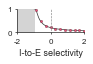

In [14]:
# ED 8e bottom I-E cut decoding accuracy
#figsize=(1.6,1.)
figsize=(1.4,1.0)

fig = figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
format_axes(ax, '0','0')

black = '#313333'

limx = [-2,2]
#limx = [-1.2,1.2]
#limx = [-1.2, 0.5]
limy1,limy2 = 0.5,1.0

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

# colors = ['w','#750b40']
# cm = define_colormap(colors,100)
# marker_cs = cm(decodacc_E_sim[i,:])
# marker_cs[0:4,:]=[1, 0, 0, 1]
for i in range(len(D_IE)):
    plot(D_EI_1, decodacc_E[i,:], lw=0.7, color=black)
    plot(D_EI_2, decodacc_E_sim[i,:], '.', \
        markeredgewidth=0.2, markeredgecolor='k', markersize=5,               color='#e85177')
#     ysim = decodacc_E_sim[i,:]
#     plt.scatter(D_EI_2, ysim, c=ysim, s=10, linewidths = 0.5, edgecolors='k',cmap=cm)

plot([0,0],[0,3],'--',lw=0.6, color='grey')
a = abs(D_EI[0])
fill_between([-2,-1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

xlabel('I-to-E selectivity')
#ylabel('Decod. \naccuracy')
plt.xlim(limx)
plt.ylim((limy1,limy2))

tight_layout()
# plt.savefig(figsDir+'ED5d_bottom_decoding_accuracy_EI_cut.pdf',bbox_inches='tight')

0 of 4
1 of 4
2 of 4
3 of 4
4 of 4


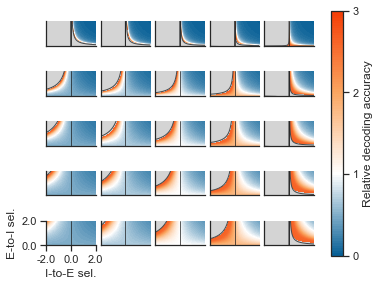

In [16]:
# Ext Data Fig. 8f 

S_EE = 2
S_EI = 2
S_IE = 2
S_II = 2

DD_EE = [-1.1,-0.5,0,0.5,1.1]
DD_II = [-1.1,-0.5,0,0.5,1.1]


# fig = figure(figsize=(6,4.5))
sns.set(rc={'figure.figsize':(6,4.5)}, font_scale=1, style='ticks')
fig,axes = subplots(len(DD_II), len(DD_EE), figsize=(6,4.5))
plt.subplots_adjust(hspace = .1, wspace=0.1)

ii=0

for i_II in range(len(DD_II)):
    D_II = DD_II[i_II]
    print(f'{i_II} of {len(DD_II)-1}')
    for i_EE in range(len(DD_EE)):
        D_EE = DD_EE[i_EE]

        n = 50
        D_EI = linspace(-S_EI, S_EI, n)
        D_IE = linspace(0, S_IE, n)

        selectivity_E1    = empty((len(D_IE),len(D_EI)))
        selectivity_E2    = empty((len(D_IE),len(D_EI)))
        selectivity_I1    = empty((len(D_IE),len(D_EI)))
        selectivity_I2    = empty((len(D_IE),len(D_EI)))
        decodacc_E     = empty((len(D_IE),len(D_EI)))
        decodacc_EI    = empty((len(D_IE),len(D_EI)))
        decodacc_E_sh  = empty((len(D_IE),len(D_EI)))
        decodacc_EI_sh = empty((len(D_IE),len(D_EI)))

        selectivity_E1_0    = empty((len(D_IE),len(D_EI)))
        selectivity_E2_0    = empty((len(D_IE),len(D_EI)))
        selectivity_I1_0    = empty((len(D_IE),len(D_EI)))
        selectivity_I2_0    = empty((len(D_IE),len(D_EI)))
        decodacc_E_0     = empty((len(D_IE),len(D_EI)))
        decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
        decodacc_E_sh_0  = empty((len(D_IE),len(D_EI)))
        decodacc_EI_sh_0 = empty((len(D_IE),len(D_EI)))

        amplification = empty((len(D_IE),len(D_EI)))
        suppression = empty((len(D_IE),len(D_EI)))

        N = 4
        sigma_input = 0
        sigma_obs = 1
        R0 = zeros(N)
        f = lambda x:x

        for i_EI in range(len(D_EI)):
            for i_IE in range(len(D_IE)):

                if (1-D_EE)*(1+D_II)+ D_EI[i_EI] * D_IE[i_IE] < 1e-15:
                    decodacc_EI[i_IE, i_EI]     = nan
                    decodacc_E[i_IE, i_EI]      = nan
                    decodacc_EI_sh[i_IE, i_EI]  = nan
                    decodacc_E_sh[i_IE, i_EI]   = nan

                else:
                    # set connectivity matrix
                    S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
                    D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
                    Win  = 0.5 * (S + D)
                    Wout = 0.5 * (S - D)

                    alpha = 1-S_EE+S_EI*S_IE
                    delta = 1-D_EE+D_EI[i_EI]*D_IE[i_IE]

                    amplification[i_IE, i_EI] = (1/alpha+1/delta)/2
                    suppression[i_IE, i_EI] = (1/alpha-1/delta)/2

                    J    = block([[Win, Wout], [Wout, Win]])
                    Net = RecurrentNet(J, sigma_input)
                    _ = Net.covariance()
                    dh1 = array([1,0,0,0])
                    dh2 = array([0,0,1,0])
                    dh = dh1 - dh2

                    cov = sigma_obs * eye(N)
                    decodacc_EI[i_IE, i_EI], decodacc_EI_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
                    decodacc_E[i_IE, i_EI], decodacc_E_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0, 2])
                    # selectivity_E1[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_I1[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_E2[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_I2[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

                    J = zeros((N,N))
                    Net = RecurrentNet(J, sigma_input)
                    _ = Net.covariance()
                    decodacc_EI_0[i_IE, i_EI], decodacc_EI_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
                    decodacc_E_0[i_IE, i_EI], decodacc_E_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
                    # selectivity_E1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_I1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_E2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
                    # selectivity_I2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)


        # ax = fig.add_subplot(len(DD_II), len(DD_EE), ii)
        ax = axes[i_II, i_EE]
        format_axes(ax)
        DD_EI, DD_IE = meshgrid(D_EI, D_IE)
        delta = (1 - D_EE)*(1 + D_II) + DD_EI*DD_IE

        colors = ['w','#750b40'] #bordeaux
        # colors = ['#086096','w','#c93a60','#851835']
        # colors = ['#086096','w','#851835']
        colors = ['#086096', 'w', '#faa661', '#f53d05']
        cm = define_colormap(colors,100)

        Z = abs((decodacc_E-0.5)/(decodacc_E_0-0.5))
        # Z = decodacc_E

        Z[delta<0] = nan
        cm.set_bad(color='#d4d4d4')

        # clim = (0.8,1.4)
        clim = (0., 3)
        # clim = (0.5,1)
        c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')

        x1 = linspace(-2,(D_EE-1)*(1+D_II)/2,1000)
        x2 = linspace(-(D_EE-1)*(1+D_II)/2,2,1000)
        ax.plot(x1, (D_EE-1)*(1+D_II)/x1, lw=1, color='#48494a')
        ax.plot(x2, (D_EE-1)*(1+D_II)/x2, lw=1, color='#48494a')

        # plot([-S_EI,S_EI],[0,0],'-',color='k', lw=.7)
        ax.plot([0,0],[0,S_IE],'-',color='k', lw=.7)
        # plot([-2,2],[-1,-1], lw=0.6, ls='--', color='k')

        ax.set_xlim(-2, 2)
        ax.set_ylim(0, 2)
        ticks = (0,1,2,3)

        # print(i_II, i_EE, ii)
        if ii==20:
            # cbar = fig.colorbar(c, ticks=ticks, fraction=0.025).set_label('Rel. decod. acc.')
            ax.set_xlabel('I-to-E sel.')
            ax.set_ylabel('E-to-I sel.')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
            pass

        ii = ii + 1
sns.despine()
fig.colorbar(c, ax=axes.ravel().tolist(), ticks=ticks).set_label('Relative decoding accuracy')
#plt.savefig(figsDir+'ED_6.pdf',bbox_inches='tight', dpi=300)

In [2]:
#Set up panels ED 8g,h,left
# May need to clear formatting settings to get fig font scale correct
n = 120
S_EE = 0
S_EI = 2
S_IE = 2
S_II = 0.

D_EE = S_EE
D_EI = linspace(-S_EI, S_EI, n)
D_IE = linspace(0, S_IE, n)
D_II = 0.


selectivity_E1    = empty((len(D_IE),len(D_EI)))
selectivity_E2    = empty((len(D_IE),len(D_EI)))
selectivity_I1    = empty((len(D_IE),len(D_EI)))
selectivity_I2    = empty((len(D_IE),len(D_EI)))
decodacc_E     = empty((len(D_IE),len(D_EI)))
decodacc_EI    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh = empty((len(D_IE),len(D_EI)))

selectivity_E1_0    = empty((len(D_IE),len(D_EI)))
selectivity_E2_0    = empty((len(D_IE),len(D_EI)))
selectivity_I1_0    = empty((len(D_IE),len(D_EI)))
selectivity_I2_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh_0  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh_0 = empty((len(D_IE),len(D_EI)))

amplification = empty((len(D_IE),len(D_EI)))
suppression = empty((len(D_IE),len(D_EI)))

N = 4
sigma_input = 1
sigma_obs = 0.
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_sh[i_IE, i_EI]  = nan
            decodacc_E_sh[i_IE, i_EI]   = nan

        else:
            # set connectivity matrix
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            alpha = 1-S_EE+S_EI*S_IE
            delta = 1-D_EE+D_EI[i_EI]*D_IE[i_IE]

            amplification[i_IE, i_EI] = (1/alpha+1/delta)/2
            suppression[i_IE, i_EI] = (1/alpha-1/delta)/2

            J    = block([[Win, Wout], [Wout, Win]])
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            # cov = sigma_obs * eye(N)
            decodacc_EI[i_IE, i_EI], decodacc_EI_sh[i_IE, i_EI] = Net.compute_acc_analytical(dh)
            decodacc_E[i_IE, i_EI], decodacc_E_sh[i_IE, i_EI] = Net.compute_acc_analytical(dh, idx = [0, 2])
            # selectivity_E1[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], decodacc_EI_sh_0[i_IE, i_EI] = Net.compute_acc_analytical(dh)
            decodacc_E_0[i_IE, i_EI], decodacc_E_sh_0[i_IE, i_EI] = Net.compute_acc_analytical(dh, idx=[0, 2])
            # selectivity_E1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)



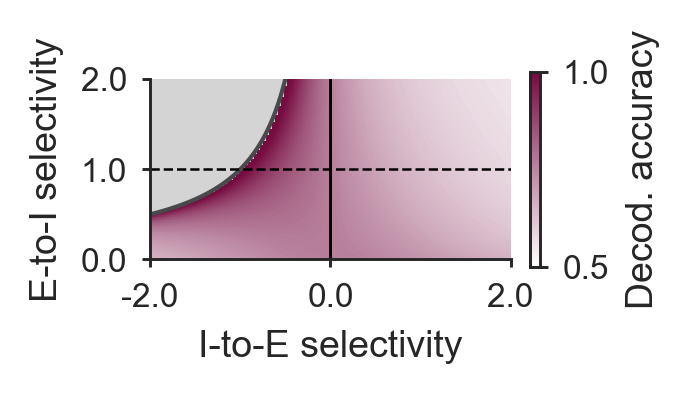

In [3]:
# ED Fig. 8g, left
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.4,1.9))
colors = ['w','#750b40'] #bordeaux
cm = define_colormap(colors,100)

Z = decodacc_E
Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')

clim = (0.5,1)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')
cbar = fig.colorbar(c, ticks=(0.5,1), fraction=0.025).set_label('Decod. accuracy')

x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')
xlim = (-2,2)
ylim = (0,2)
xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
tight_layout()
sns.despine()
#plt.savefig(figsDir+'ED8g_left.pdf',bbox_inches='tight', dpi=300)

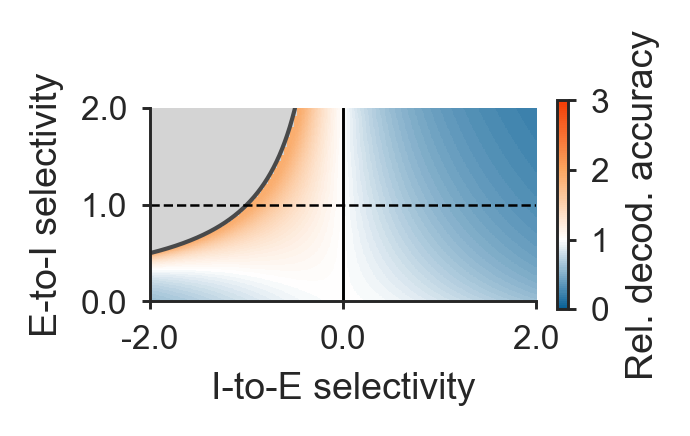

In [4]:
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.4,1.9))
# colors = ['#086096','w','#f53d05']
colors = ['#086096', 'w', '#faa661', '#f53d05']
cm = define_colormap(colors,100)

Z = abs((decodacc_E-0.5)/(decodacc_E_0-0.5))
Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')

clim = (0.,3)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')
cbar = fig.colorbar(c, ticks=(0.,1,2,3), fraction=0.025).set_label('Rel. decod. accuracy')

x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')
xlim = (-2,2)
ylim = (0,2)
xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
tight_layout()
#plt.savefig(figsDir+'ED8h_left.pdf',bbox_inches='tight', dpi=300)

In [5]:
# Set up fig. ED 8g-h, right
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
# D_EI = linspace(-S_EI, S_EI, n)
D_EI = linspace(-1.5, 1.5, n)
D_IE = array([1])
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))
decodacc_E1      = empty((len(D_IE),len(D_EI)))
decodacc_E2      = empty((len(D_IE),len(D_EI)))
decodacc_I1      = empty((len(D_IE),len(D_EI)))
decodacc_I2      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E1_0    = empty((len(D_IE),len(D_EI)))
decodacc_E2_0    = empty((len(D_IE),len(D_EI)))
decodacc_I1_0    = empty((len(D_IE),len(D_EI)))
decodacc_I2_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 1
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan

            decodacc_E1[i_IE, i_EI]   = nan
            decodacc_E2[i_IE, i_EI]   = nan
            decodacc_E1_0[i_IE, i_EI] = nan
            decodacc_E2_0[i_IE, i_EI] = nan

            decodacc_I1[i_IE, i_EI]   = nan
            decodacc_I2[i_IE, i_EI]   = nan
            decodacc_I1_0[i_IE, i_EI] = nan
            decodacc_I2_0[i_IE, i_EI] = nan

        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2
            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical(dh)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical(dh, idx = [0,2])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical(dh, idx=[0, 2])

##

# set parameters
T = 50
nsteps = 500
t = linspace(0, T, nsteps)
N = 4
ntrials = 500
R0 = zeros(N)
f = lambda x:x

R_singletrials_1 = empty((N,ntrials))
R_singletrials_2 = empty((N,ntrials))

nsim = 12
D_EI = linspace(D_EI[0], D_EI[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E_0_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_0_sim      = empty((len(D_IE),len(D_EI)))

for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(f'{i_EI} of {len(D_EI)}')

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan
            decodacc_EI_0_sim[i_IE, i_EI] = nan
            decodacc_E_0_sim[i_IE, i_EI] = nan

        else:
            # print(d)
            for i_trial in range(ntrials):
                # set first input and compute fixed point
                h1 = array([1,0,0,0])
                h2 = array([0,0,1,0])
                h1 = h1 / linalg.norm(h1-h2)
                h2 = h2 / linalg.norm(h1-h2)
                input = outer(h1, ones(nsteps))
                pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_1 = R[:,-1]
                R_singletrials_1[:,i_trial] = fp_1

                # set second input and compute fixed point
                input = outer(h2, ones(nsteps))
                pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_2 = R[:, -1]
                R_singletrials_2[:,i_trial] = fp_2


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf.set_K(10)
            clf_E.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())

            for i_trial in range(ntrials):
                J = np.zeros((N,N))
                h1 = array([1,0,0,0])
                h2 = array([0,0,1,0])
                h1 = h1 / linalg.norm(h1-h2)
                h2 = h2 / linalg.norm(h1-h2)
                input = outer(h1, ones(nsteps))
                pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_1 = R[:,-1]
                R_singletrials_1[:,i_trial] = fp_1

                # set second input and compute fixed point
                input = outer(h2, ones(nsteps))
                pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_2 = R[:, -1]
                R_singletrials_2[:,i_trial] = fp_2

            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf.set_K(10)
            clf_E.set_K(10)
            decodacc_EI_0_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_0_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())


0 of 12
1 of 12
2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12


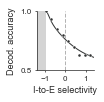

In [6]:
# ED Fig. 8g, right
fig = figure(figsize=(1.5,1.5))
black = '#313333'
labels = [r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 0$', r'$\Delta_{IE} = -1$']
limy1,limy2 = 0.5,1.

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

for i in range(len(D_IE)):
    plot(D_EI_1, decodacc_E[i, :], lw=1., color=black, label=labels[i])
    plot(D_EI_2, decodacc_E_sim[i, :], '.', \
         markeredgewidth=0.4, markeredgecolor='w', markersize=6, color=black)

plot([0,0], [limy1,limy2], '--', lw=1, color='#b3b3b3')
a = abs(D_EI[0]+0.1)
fill_between([-1.5, -1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')
xlabel(r'I-to-E selectivity')
ylabel('Decod. accuracy')
plt.xlim([-a,a])
plt.ylim([limy1,limy2])
yticks([0.5,1])
tight_layout()
#plt.savefig(figsDir+'ED8g_right.pdf',bbox_inches='tight', dpi=300)

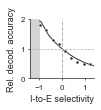

In [7]:
# ED Fig. 8h, right
fig = figure(figsize=(1.5,1.5))
black = '#313333'
labels = [r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 0$', r'$\Delta_{IE} = -1$']

limy1,limy2 = 0,2

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

for i in range(len(D_IE)):
    plot(D_EI_1, ((decodacc_E-0.5) / (decodacc_E_0-0.5))[i, :], lw=1., color=black, label=labels[i])
    plot(D_EI_2, ((decodacc_E_sim-0.5) / (decodacc_E_0_sim-0.5))[i, :], '.', \
         markeredgewidth=0.4, markeredgecolor='w', markersize=6, color=black)

plot([0,0], [limy1,limy2], '--', lw=1, color='#b3b3b3')
plot([-1.5,1.5], [1,1], '--', lw=0.7, color='#b3b3b3')
a = abs(D_EI[0]+0.1)
fill_between([-1.5, -1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')
xlabel(r'I-to-E selectivity')
ylabel('Rel. decod. accuracy')
plt.xlim([-a,a])
plt.ylim([limy1,limy2])
yticks([0,1,2])
tight_layout()
# plt.savefig(figsDir+'ED8h_right.pdf',bbox_inches='tight', dpi=300)

In [8]:
# Prep ED Fig. 8i,j left
n = 120
S_EE = 0
S_EI = 2
S_IE = 2
S_II = 0.

D_EE = S_EE
D_EI = linspace(-S_EI, S_EI, n)
D_IE = linspace(0, S_IE, n)
D_II = 0.

decodacc_E     = empty((len(D_IE),len(D_EI)))
decodacc_EI    = empty((len(D_IE),len(D_EI)))
decodacc_I    = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_I_0    = empty((len(D_IE),len(D_EI)))

N = 4
sigma_input = 1
sigma_obs = 0.
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_I[i_IE, i_EI]      = nan

            decodacc_EI_0[i_IE, i_EI]  = nan
            decodacc_E_0[i_IE, i_EI]   = nan
            decodacc_I_0[i_IE, i_EI]   = nan

        else:
            # set connectivity matrix
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            Net = RecurrentNet(J, sigma_input)
            cov = Net.covariance_steadynoise()

            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0, 2])
            decodacc_I[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [1, 3])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            cov = Net.covariance_steadynoise()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            decodacc_I_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[1, 3])


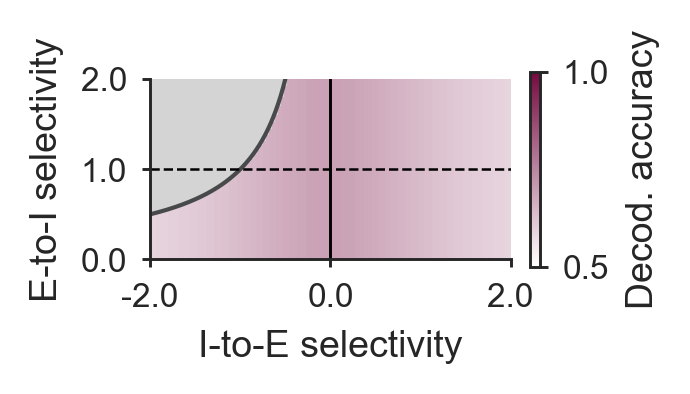

In [9]:
# ED Fig i left 
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.4,1.9))
colors = ['w','#750b40'] #bordeaux
cm = define_colormap(colors,100)

Z = decodacc_E
Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')

clim = (0.5,1)
c = ax.imshow(Z,clim = clim, cmap=cm, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')
cbar = fig.colorbar(c, ticks=(0.5,1), fraction=0.025).set_label('Decod. accuracy')

x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')

xlim = (-2,2)
ylim = (0,2)
xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
tight_layout()
#plt.savefig(figsDir+'ED8i_left.pdf',bbox_inches='tight', dpi=300)

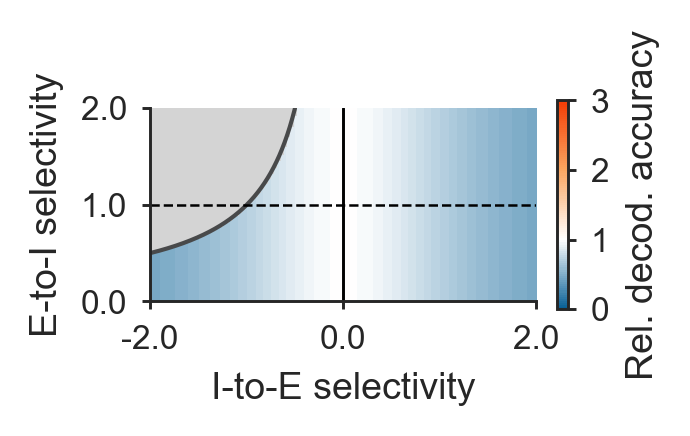

In [10]:
# Fig ED8 j left
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.4,1.9))
# colors = ['#086096','w','#f53d05']
colors = ['#086096', 'w', '#faa661', '#f53d05']
cm = define_colormap(colors,100)

Z = abs((decodacc_E-0.5)/(decodacc_E_0-0.5))
Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')

clim = (0.,3)
c = ax.imshow(Z,clim = clim, cmap=cm, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')
cbar = fig.colorbar(c, ticks=(0,1,2,3), fraction=0.025).set_label('Rel. decod. accuracy')

x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')
xlim = (-2,2)
ylim = (0,2)
xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
tight_layout()
#plt.savefig(figsDir+'ED8j_left.pdf',bbox_inches='tight', dpi=300)

In [11]:
# Prep ED Fig. 8 i,j right
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
D_EI = linspace(-1.5, 1.5, n)
D_IE = array([1])
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 1
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan


        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            cov = Net.covariance_steadynoise()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2
            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh,cov)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh,cov, idx = [0,2])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            cov = Net.covariance_steadynoise()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh,cov)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh,cov, idx=[0, 2])

##

# set parameters
T = 50
nsteps = 500
t = linspace(0, T, nsteps)
N = 4
ntrials = 500
R0 = zeros(N)
f = lambda x:x

R_singletrials_1 = empty((N,ntrials))
R_singletrials_2 = empty((N,ntrials))

nsim = 12
D_EI = linspace(D_EI[0], D_EI[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E_0_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_0_sim      = empty((len(D_IE),len(D_EI)))

for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(f'{i_EI} of {len(D_EI)-1}')

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan
            decodacc_EI_0_sim[i_IE, i_EI] = nan
            decodacc_E_0_sim[i_IE, i_EI] = nan

        else:
            for i_trial in range(ntrials):
                # set first input and compute fixed point
                h1 = array([1,0,0,0])
                h2 = array([0,0,1,0])
                h1 = h1 / linalg.norm(h1-h2)
                h2 = h2 / linalg.norm(h1-h2)
                input = outer(h1 + random.normal(0, sigma_input, N), ones(nsteps))
                pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':0., 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_1 = R[:,-1]
                R_singletrials_1[:,i_trial] = fp_1

                # set second input and compute fixed point
                input = outer(h2 + random.normal(0, sigma_input, N), ones(nsteps))
                pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': 0., 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_2 = R[:, -1]
                R_singletrials_2[:,i_trial] = fp_2


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf.set_K(10)
            clf_E.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())

            for i_trial in range(ntrials):
                J = np.zeros((N,N))
                h1 = array([1,0,0,0])
                h2 = array([0,0,1,0])
                h1 = h1 / linalg.norm(h1-h2)
                h2 = h2 / linalg.norm(h1-h2)
                input = outer(h1 + random.normal(0, sigma_input, N), ones(nsteps))
                pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':0., 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_1 = R[:,-1]
                R_singletrials_1[:,i_trial] = fp_1

                # set second input and compute fixed point
                input = outer(h2 + random.normal(0, sigma_input, N), ones(nsteps))
                pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma':0., 'f': lambda x:x}
                R = simulate_rate_model(pars)
                fp_2 = R[:, -1]
                R_singletrials_2[:,i_trial] = fp_2

            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf.set_K(10)
            clf_E.set_K(10)
            decodacc_EI_0_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_0_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())

0 of 11
1 of 11
2 of 11
3 of 11
4 of 11
5 of 11
6 of 11
7 of 11
8 of 11
9 of 11
10 of 11
11 of 11


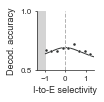

In [17]:
# ED Fig. 8i right

fig,ax = subplots(figsize=(1.5,1.5))
black = '#313333'
labels = [r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 0$', r'$\Delta_{IE} = -1$']

limy1,limy2 = 0.5,1.

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

for i in range(len(D_IE)):
    plot(D_EI_1, decodacc_E[i, :], lw=1., color=black, label=labels[i])
    plot(D_EI_2, decodacc_E_sim[i, :], '.', \
         markeredgewidth=0.4, markeredgecolor='w', markersize=6, color=black)

plot([0,0], [limy1,limy2], '--', lw=1, color='#b3b3b3')

a = abs(D_EI[0]+0.1)
fill_between([-1.5, -1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

xlabel(r'I-to-E selectivity')
ylabel('Decod. accuracy')
ax.set_xlim([-a,a])
ax.set_ylim([limy1,limy2])
yticks([0.5,1])
tight_layout()
# plt.savefig(figsDir+'ED8i_right.pdf',bbox_inches='tight', dpi=300)

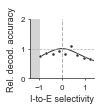

In [15]:
# ED Fig 8j right
fig,ax = subplots(figsize=(1.5,1.5))
black = '#313333'
labels = [r'$\Delta_{IE} = 1$', r'$\Delta_{IE} = 0$', r'$\Delta_{IE} = -1$']

limy1,limy2 = 0,2
# limy1,limy2 = 0.5,1.

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

for i in range(len(D_IE)):
    plot(D_EI_1, ((decodacc_E-0.5) / (decodacc_E_0-0.5))[i, :], lw=1., color=black, label=labels[i])
    plot(D_EI_2, ((decodacc_E_sim-0.5) / (decodacc_E_0_sim-0.5))[i, :], '.', \
         markeredgewidth=0.4, markeredgecolor='w', markersize=6, color=black)

plot([0,0], [limy1,limy2], '--', lw=1, color='#b3b3b3')
plot([-1.5,1.5], [1,1], '--', lw=0.7, color='#b3b3b3')

a = abs(D_EI[0]+0.1)
fill_between([-1.5, -1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

xlabel(r'I-to-E selectivity')
ylabel('Rel. decod. accuracy')
ax.set_xlim([-a,a])
ax.set_ylim([limy1,limy2])
yticks([0.,1,2])
tight_layout()
#plt.savefig(figsDir+'ED8j_right.pdf',bbox_inches='tight', dpi=300)
